02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [30]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [31]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240624_train.csv')
test = pd.read_csv('../data/processed/processed20240624_test.csv')
# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [32]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [33]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [34]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.77768
[200]	valid_0's rmse: 3.73092
[300]	valid_0's rmse: 3.70743
[400]	valid_0's rmse: 3.69485
[500]	valid_0's rmse: 3.68793
[600]	valid_0's rmse: 3.68341
[700]	valid_0's rmse: 3.67993
[800]	valid_0's rmse: 3.67793
[900]	valid_0's rmse: 3.67671
[1000]	valid_0's rmse: 3.67569
[1100]	valid_0's rmse: 3.67496
[1200]	valid_0's rmse: 3.67424
[1300]	valid_0's rmse: 3.67345
[1400]	valid_0's rmse: 3.67307
[1500]	valid_0's rmse: 3.67254
[1600]	valid_0's rmse: 3.67249
[1700]	valid_0's rmse: 3.67243
[1800]	valid_0's rmse: 3.67254
Early stopping, best iteration is:
[1693]	valid_0's rmse: 3.67234
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70656
[200]	valid_0's rmse: 3.66404
[300]	valid_0's rmse: 3.64342
[400]	valid_0's rmse: 3.63259
[500]	valid_0's rmse: 3.62724
[600]	valid_0's rmse: 3.62356
[700]	valid_0's rmse: 3.62143
[800]	valid_0's rmse: 3.61993
[90

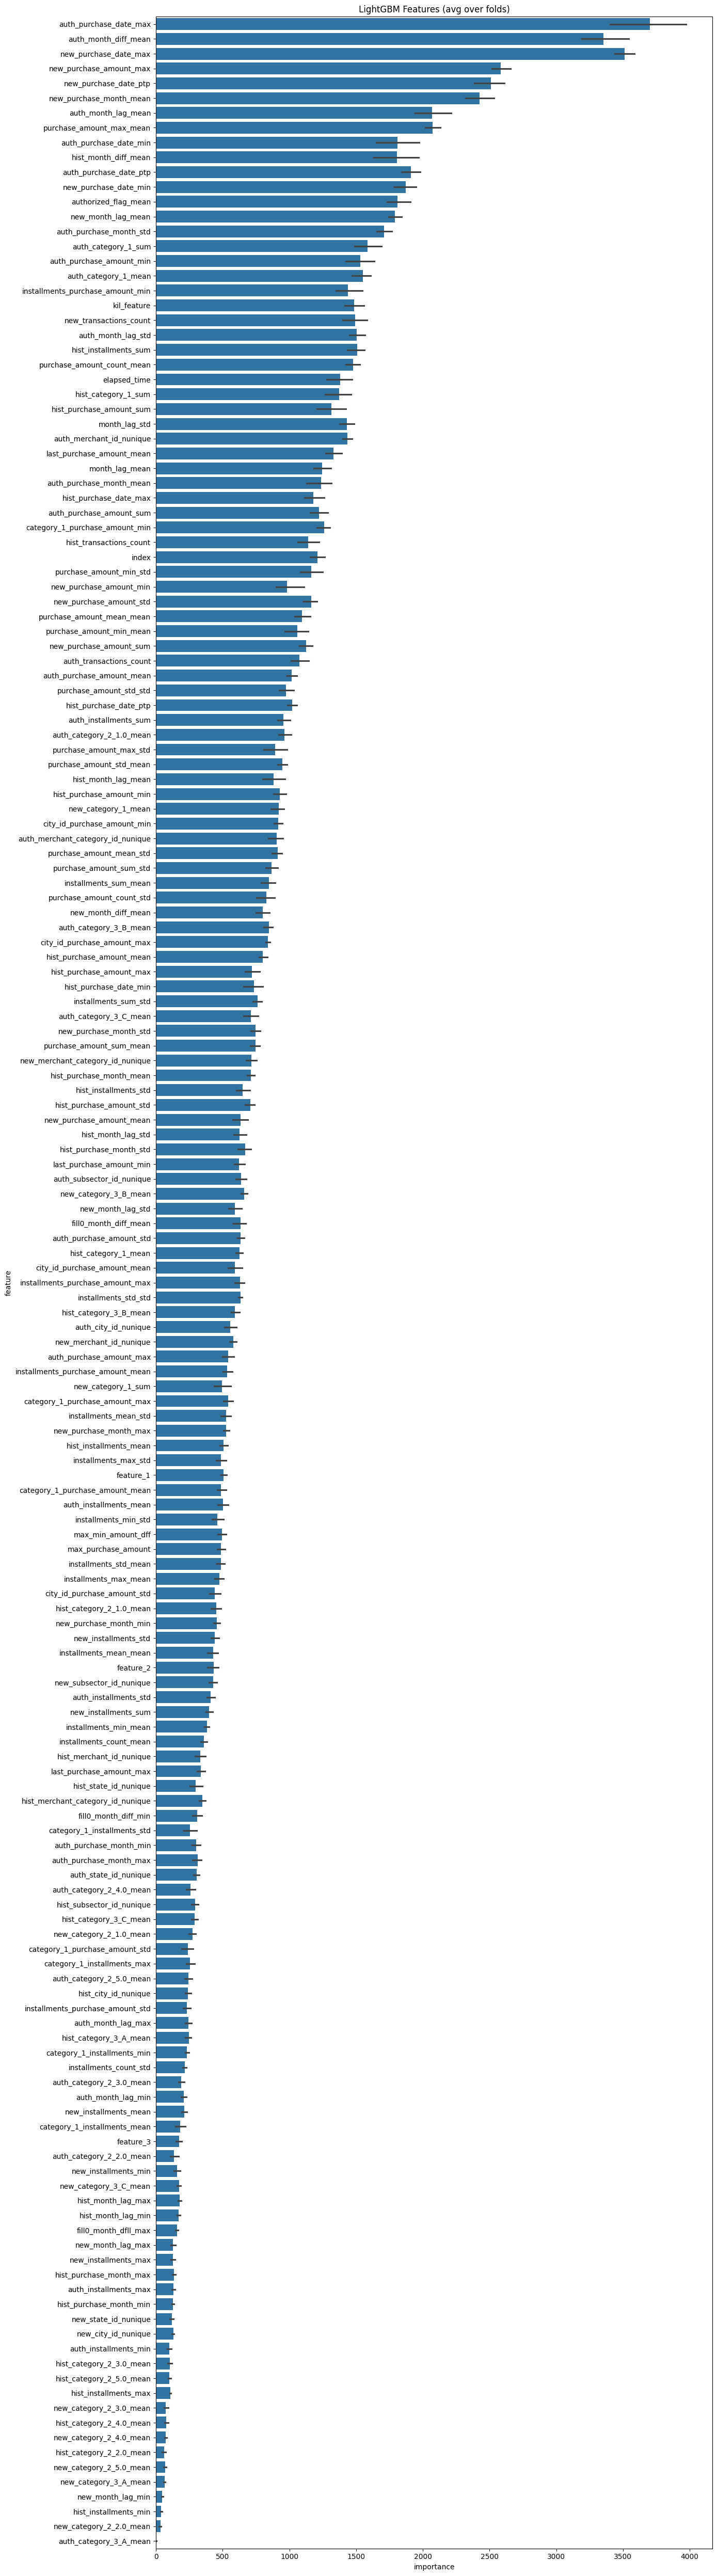

In [35]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')